<a href="https://colab.research.google.com/github/BubuDavid/Fundamentos-de-Procesamiento-Digital-de-Imagenes/blob/main/tareas/tarea5/Tarea5_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se puede ver el notebook con el código en el siguiente link: https://colab.research.google.com/drive/1Yh8mqTsReJKtW-Psa4Q-RjeTwxQPT5sK?usp=sharing

# Imports

In [1]:
# Importando librerías
import cv2 # Para manejar imágenes
import matplotlib.pyplot as plt # Para visualizar las imágenes (Se puede hacer de otra manera con una librería de google pero meh, este está bueno)
import numpy as np # Para operar matrices de manera sencilla

# Funciones auxiliares

In [2]:
# Desplegar histogramas
def show_histograms(imgs, bin_value = 20, colors = [None, "r"], titles = ["Normal", "No normal"], normalized = True, edgecolor = "black", cumulative = False, **kwargs):
    if type(imgs) != list:
        imgs = [imgs]
    if type(titles) != list:
        titles = [titles]
    
    flattens = np.array(list(map(lambda img: img.ravel(), imgs)))
    bins = np.array([np.linspace(0, 255, bin_value) for i in range(len(imgs))])
    hists = []
    fig, ax = plt.subplots(1, len(imgs), figsize = (10, 3))
    
    if len(imgs) == 1:
        img, b = imgs[0], bins[0]
        
        hist, b = np.histogram(img, bins = b)
        if normalized:
            hist = hist / img.size
        if cumulative:
            hist = np.cumsum(hist)
        ax.hist(b[:-1], b, weights = hist, color = colors[0], edgecolor = edgecolor, **kwargs)
        ax.set_title(titles[0])
        return hist, b
    else:
        for index in range(len(flattens)):
            img, b = imgs[index], bins[index]
            hist, b = np.histogram(img, bins = b)
            if normalized:
                hist = hist / img.size
            if cumulative:
                hist = np.cumsum(hist)
            
            ax[index].hist(b[:-1], b, weights = hist, color = colors[index], edgecolor = edgecolor, **kwargs)
            ax[index].set_title(titles[index])
            hists.append(hist)
    return hists, bins

In [3]:
# Transformación Negativa
def imcomplement(img):
    return np.abs(255 - img)

In [4]:
# Credits: https://www.nzfaruqui.com/contrast-stretching-in-image-processing-using-matlab/
def imadjust(img,lim_in = [0, 1], lim_out = [0, 1], gamma=1, plot = False):
    c, d = lim_in
    a, b = lim_out
    # Normalización para que esto funcione
    img_cp = img.copy()
    if np.max(img_cp) > 1:
        img_cp = img_cp / np.max(img_cp)

    # Básicamente esto es lo que hace imadjust ☝ ver la fuente para mayor información
    adj = (((img_cp - a) / (b - a)) ** gamma) * (d - c) + c
    # Regresando a las dimensiones originales
    adj = np.int64(adj / np.max(adj) * 255)

    # Grafica la función
    if plot:
        x = np.linspace(0, 1, 1000)
        y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
        plt.plot(x,y, c='g')
        plt.title(f'Función adjust con a={a}, b={b}, c={c}, d={d}, gamma={gamma}')
    return adj

In [5]:
# Mostrar imágenes
def show_img(img, size = (7, 7), schema = [1,1], is_gray = False, info = False):
    fig, axs = plt.subplots(*schema, figsize=size)
    if is_gray:
        axs.imshow(img, cmap='gray', vmin=0, vmax=255)
    else:
        axs.imshow(img)
    axs.axis("off")

    if info:
        print(f"Imagen de dimensiones: {img.shape}, con un total de {img.size} pixeles")

In [6]:
# Mostrar varias imágenes
def show_imgs_row(imgs, size = (5,5), is_gray = False, info = False, titles = None):
    schema = (1, len(imgs))
    options = {}
    if is_gray:
        options["cmap"] = "gray"
        options["vmin"] = 0
        options["vmax"] = 255

    fig, axs = plt.subplots(*schema, figsize=size)

    for index in range(len(imgs)):
        axs[index].imshow(imgs[index], **options)
        axs[index].axis("off")
        if titles:
            axs[index].set_title(titles[index])

In [7]:
# Leer imagen
def read_img(img_name, **kwarg):
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    show_img(img, size = None, is_gray = True, info = True, **kwarg)
    return img

In [8]:
# Binarize images
def binarize(img, max_val):
    return (img >= max_val) * 255

# 1. Usando la imagen Fig0310(a).tif:

Imagen de dimensiones: (1000, 683), con un total de 683000 pixeles


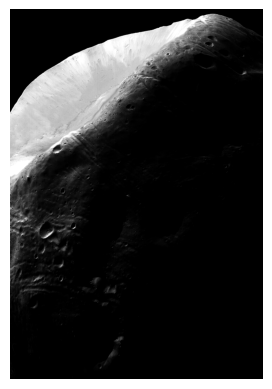

In [ ]:
img = read_img("Fig0310(a).tif")

## a. Reporte la función de distribución de probabilidades de las intensidades (recuerde, histograma normalizado).

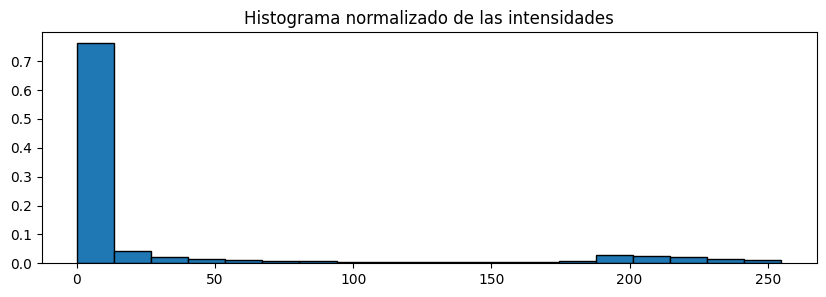

In [ ]:
hist, bins = show_histograms(
    imgs = [img],
    titles = [
        "Histograma normalizado de las intensidades"
    ]
)

## b. Calcule la función de distribución acumulada (histograma acumulado normalizado).

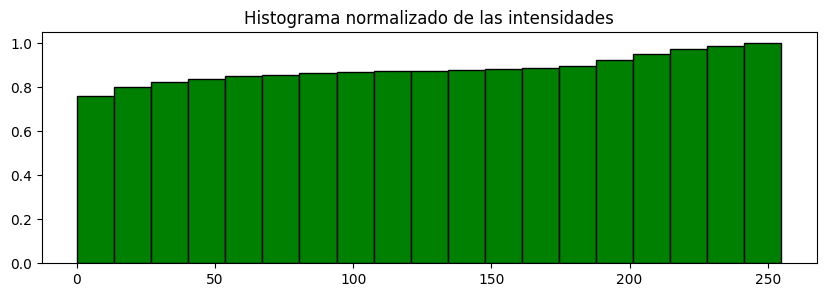

In [ ]:
hist, bins = show_histograms(
    imgs = [img],
    titles = [
        "Histograma normalizado de las intensidades"
    ],
    cumulative = True,
    colors = ["g"]
)